In [1]:
# LSTM for Sunspot Number Analysis
# based on https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
# imports
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)):
        if i + look_back < len(dataset):
            dataY.append(dataset[i + look_back, 0])
        else: 
            dataY.append(0)
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
# graphic cleanup and initialization function
def initPyPlot(h=8):
    plt.close()
    figprops = dict(figsize=(11,h), dpi=96)
    fig = plt.figure(**figprops)
    return plt.axes()

In [5]:
# loss logging each N epochs
import time as ttt
current_milli_time = lambda: int(round(ttt.time() * 1000))
class NEpochsLogger(tf.keras.callbacks.Callback):
    def __init__(self,display=10):
        '''
        display: Number of epochs to wait before outputting loss
        '''
        self.display = display
        self.starttime = current_milli_time()
        self.lastepoch = 0

    def logtime(self,logs={}):
        deltatime=current_milli_time()-self.starttime
        print ('Epoch {0} -> loss: {1} time: {2}s'.format(self.lastepoch,logs.get('loss'),deltatime/1000))

    def on_epoch_begin(self, epoch, logs={}):
        self.lastepoch = epoch
        if epoch % self.display == 1:
            self.starttime=current_milli_time()

    def on_epoch_end(self, epoch, logs={}):
        self.lastloss=logs.get('loss')
        if epoch!=0 and epoch % self.display == 0:
            self.logtime(logs)
            self.starttime=0

    def on_train_end(self, logs={}):
        self.logtime({'loss':self.lastloss})

In [6]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[numpy.int(window_len/2-1):-numpy.int(window_len/2)]


In [221]:
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = pd.read_csv('data/SN_m_tot_V2.0.csv',sep=';',usecols=[2,3], engine='python')
time = dataframe['DATEFRACTION']
ssn_orig = dataframe['SSN']
ssn=smooth(ssn_orig,14,'blackman')
orig_dataset=ssn.reshape(-1,1)

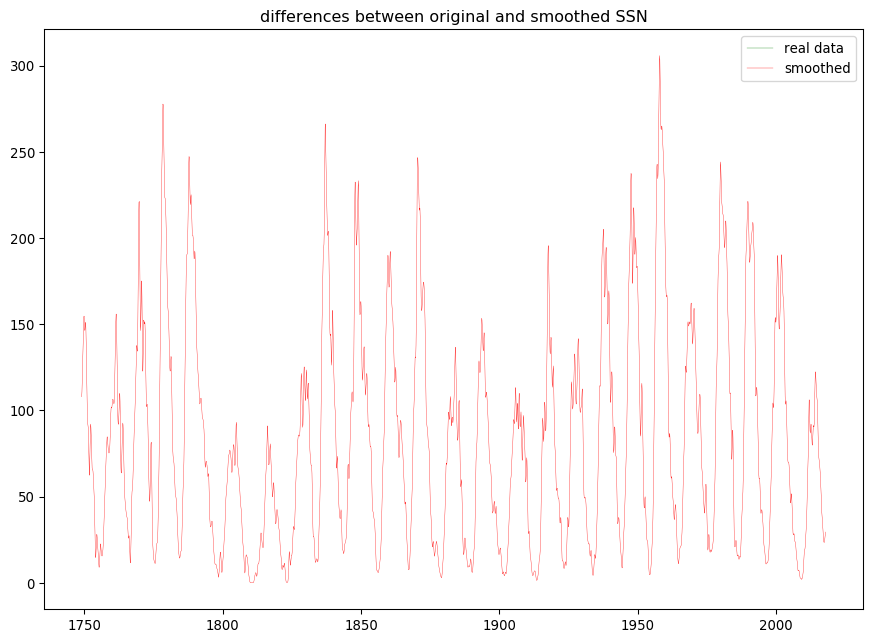

In [222]:
# plot baseline and predictions
sx=initPyPlot()
#p1,=sx.plot(time,ssn_orig,color="green",linewidth=0.25,antialiased=True)
p2,=sx.plot(time,ssn,color="red",linewidth=0.25,antialiased=True)
sx.legend([p1,p2],['real data','smoothed'])
sx.set_title('differences between original and smoothed SSN')
plt.show()

In [223]:
orig_dataset = orig_dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(orig_dataset)

In [224]:
# split into train and test sets
train_size = int(len(dataset) * 0.666)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainXR = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testXR = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [225]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=0.001)

In [226]:
def create_model(lstmsize=128,lstmdropout=0.1,generaldropout=0.2):
    m = tf.keras.models.Sequential()
    m.add(tf.keras.layers.LSTM(lstmsize, input_shape=(1, look_back), recurrent_dropout=lstmdropout))
    m.add(tf.keras.layers.Dropout(generaldropout))
    m.add(tf.keras.layers.Dense(1,activation='relu'))
    m.compile(loss='mse', optimizer='adam')
    return m

In [291]:
# create the LSTM network
model=create_model(lstmsize=64,lstmdropout=0.2,generaldropout=0.1)

In [292]:
# fit the model
# TODO tensorboard
model.fit(trainXR, trainY, epochs=400, batch_size=512, verbose=0, callbacks=[NEpochsLogger(50),reduce_lr])

Epoch 50 -> loss: 0.001083483123671423 time: 2.328s
Epoch 100 -> loss: 0.0005948780307431793 time: 2.375s
Epoch 150 -> loss: 0.0005252531977210825 time: 2.672s
Epoch 200 -> loss: 0.000501142185256388 time: 2.984s
Epoch 250 -> loss: 0.0005180941291653778 time: 2.563s
Epoch 300 -> loss: 0.0005001542957289773 time: 2.609s
Epoch 350 -> loss: 0.00047439882291994254 time: 2.5s
Epoch 399 -> loss: 0.0004950560928752483 time: 2.531s


In [293]:
# make predictions
trainPredict = model.predict(trainXR)
testPredict = model.predict(testXR)
scr=model.evaluate(testXR,testY)
print('\n Score:',scr)
# rescale predictions
trainPredictI = scaler.inverse_transform(trainPredict)
trainYI = scaler.inverse_transform([trainY])
testPredictI = scaler.inverse_transform(testPredict)
testYI = scaler.inverse_transform([testY])

 736/1078 [===================>..........] - ETA: 0s 
 Score: 0.000309427242561


In [294]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYI[0], trainPredictI[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYI[0], testPredictI[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.37 RMSE
Test Score: 5.38 RMSE


In [295]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredictI)+look_back, :] = trainPredictI
trainPredictPlot[0:len(trainPredictI):,] = trainPredictI

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(trainPredictI)+(look_back*2)+1:len(dataset)-1, :] = testPredictI
testPredictPlot[len(trainPredictI):len(dataset) :,] = testPredictI

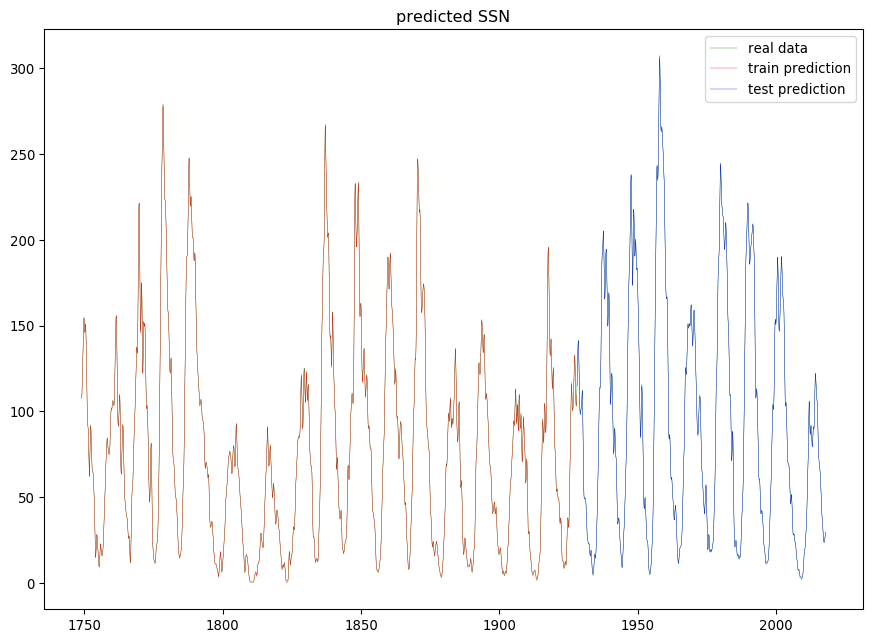

In [296]:
# plot baseline and predictions
ax=initPyPlot()
p1,=ax.plot(time,orig_dataset,antialiased=True,color="green",linewidth=0.25)
p2,=ax.plot(time,trainPredictPlot,color="red",linewidth=0.25,antialiased=True)
p3,=ax.plot(time,testPredictPlot,color="blue",linewidth=0.25,antialiased=True)
ax.legend([p1,p2,p3],['real data','train prediction','test prediction'])
ax.set_title('predicted SSN')
plt.show()

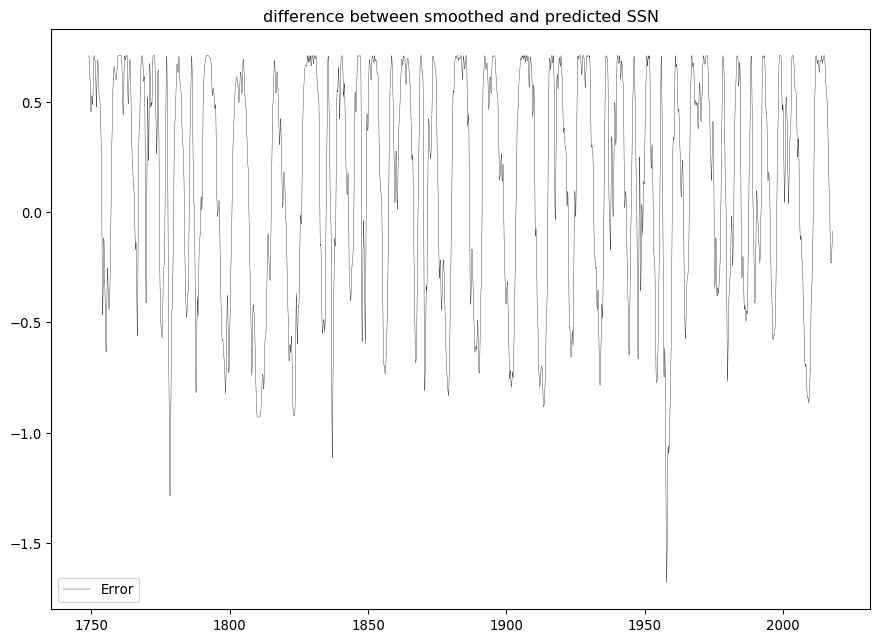

In [297]:
# plot error
bx=initPyPlot()
delta1=orig_dataset[:len(trainPredictI)]-trainPredictI
delta2=orig_dataset[len(trainPredictI):]-testPredictI
delta=numpy.concatenate([delta1.ravel(),delta2.ravel()])
pbx,=bx.plot(time,delta,antialiased=True,color="k",linewidth=0.25)
bx.legend([pbx],['Error'])
bx.set_title('difference between smoothed and predicted SSN')
plt.show()

In [298]:
# predict future
trainXF, trainYF = create_dataset(dataset, look_back)
# reshape input to be [samples, time steps, features]
trainXFR = numpy.reshape(trainXF, (trainXF.shape[0], 1, trainXF.shape[1]))

In [299]:
# create the LSTM network
modelF=create_model(lstmsize=64,lstmdropout=0.2,generaldropout=0.1)

In [301]:
# fit the model
# TODO tensorboard
modelF.fit(trainXFR, trainYF, epochs=400, batch_size=512, verbose=0, callbacks=[NEpochsLogger(50),reduce_lr])

Epoch 50 -> loss: 0.00041374085686182266 time: 3.39s
Epoch 100 -> loss: 0.0004337942435579941 time: 3.61s
Epoch 150 -> loss: 0.0004152164749612931 time: 3.234s
Epoch 200 -> loss: 0.00041081265413438493 time: 3.781s
Epoch 250 -> loss: 0.00039284733068576153 time: 3.75s
Epoch 300 -> loss: 0.00039211084916223455 time: 4.328s
Epoch 350 -> loss: 0.0003762927462044591 time: 3.625s
Epoch 399 -> loss: 0.00037430859113765115 time: 3.324s


In [302]:
# shift train predictions for plotting
trainFPredictPlot = numpy.empty_like(dataset)
trainFPredictPlot[0:len(trainPredictI):,] = trainPredictI

In [303]:
# make predictions
trainFPredict = model.predict(trainXFR)
# rescale predictions
trainFPredictI = scaler.inverse_transform(trainFPredict)
trainYFI = scaler.inverse_transform([trainYF])
# shift train predictions for plotting
trainFPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[0:len(trainFPredictI):,] = trainFPredictI

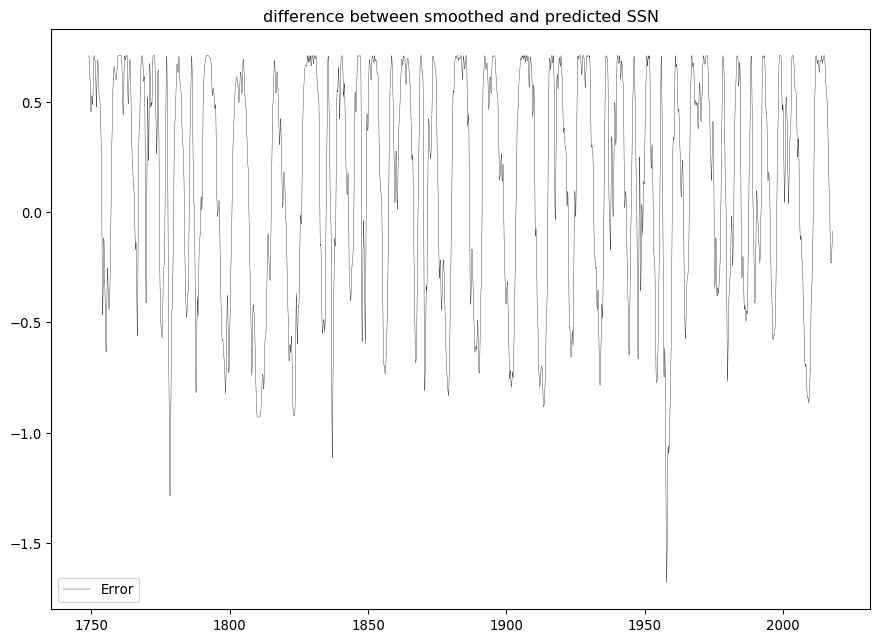

In [321]:
# plot error
bx=initPyPlot()
delta1=orig_dataset-trainFPredictI
pbx,=bx.plot(time,delta1,antialiased=True,color="k",linewidth=0.25)
bx.legend([pbx],['Error'])
bx.set_title('difference between smoothed and predicted SSN')
plt.show()

In [315]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape,trainXF.shape,trainYF.shape)

(2148, 1) (2148,) (1078, 1) (1078,) (3226, 1) (3226,)
